# UAS

In [2]:
pip install pymupdf4llm nltk networkx matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 43.8 MB/s eta 0:00:00


In [3]:
import fitz  # PyMuPDF
import nltk
import networkx as nx
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import pymupdf4llm
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict

# --- Konfigurasi Awal ---
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('punkt_tab')
except:
    pass

def main(pdf_path):
    # ==========================================
    # TAHAP 1: Ekstrak Text
    # ==========================================
    print(f"\n{'='*40}")
    print(f"TAHAP 1: EKSTRAKSI TEKS")
    print(f"{'='*40}")

    text_content = extract_text_from_pdf(pdf_path)

    # Gunakan dummy text jika PDF tidak terbaca/kosong
    if len(text_content) < 50:
        text_content = """
        Nasi goreng is a delicious Indonesian fried rice dish.
        It is distinguished from other Asian fried rice recipes by its aromatic, earthy, and smoky flavor.
        The dish is typically spiced with garlic, shallot, and chili.
        Visit https://food.com for recipes. DOIs: https://doi.org/10.1016/j.food
        """
        print("(Menggunakan teks dummy internal)")

    print(f"Jumlah Karakter: {len(text_content)}")

    # ==========================================
    # TAHAP 2: Preprocessing & Tokenisasi (Output Detail)
    # ==========================================
    print(f"\n{'='*40}")
    print(f"TAHAP 2: PREPROCESSING (CONTOH 3 TAHAP)")
    print(f"{'='*40}")

    sentences = sent_tokenize(text_content)
    print(f"Jumlah Kalimat Total: {len(sentences)}\n")

    # Kita panggil fungsi khusus yang mengembalikan contoh & data
    sequences, examples = preprocess_text_with_examples(sentences)

    # Tampilkan Contoh
    print("--- A. Contoh 3 Kalimat SEBELUM Preprocessing (Asli) ---")
    for i, s in enumerate(examples['raw']):
        print(f"{i+1}. {s}")

    print("\n--- B. Contoh 3 Kalimat SETELAH Preprocessing (Cleaning) ---")
    for i, s in enumerate(examples['cleaned']):
        print(f"{i+1}. {s}")

    print("\n--- C. Contoh 3 Kalimat SETELAH Tokenisasi (Unigram + Bigram) ---")
    for i, s in enumerate(examples['tokenized']):
        # Tampilkan sebagian jika terlalu panjang
        display_s = s[:10] + ['...'] if len(s) > 10 else s
        print(f"{i+1}. {display_s}")

    print(f"\nJumlah Sequence: {len(sequences)}")
    total_tokens = sum(len(s) for s in sequences)
    print(f"\nTotal Token Siap Proses: {total_tokens}")

    # ==========================================
    # TAHAP 3: Membangun Graph
    # ==========================================
    print(f"\n{'='*40}")
    print(f"TAHAP 3: MEMBANGUN GRAPH")
    print(f"{'='*40}")

    G = build_graph(sequences, window_size=3)
    print(f"Graph Terbentuk: {G.number_of_nodes()} Node, {G.number_of_edges()} Edge")

    # ==========================================
    # TAHAP 3b: MENAMPILKAN MATRIKS KO-OKURENSI
    # ==========================================
    print(f"\n{'='*40}")
    print(f"TAHAP 3b: MATRIKS KO-OKURENSI (CO-OCCURRENCE MATRIX)")
    print(f"{'='*40}")

    # Mengubah Graph menjadi DataFrame Pandas (Adjacency Matrix)
    # weight='weight' memastikan nilai sel adalah jumlah kemunculan bersama
    co_occurrence_matrix = nx.to_pandas_adjacency(G, weight='weight', dtype=int)

    print(f"Ukuran Matriks: {co_occurrence_matrix.shape}")
    print("Contoh Matriks (10x10 Data Pertama):")

    # Menampilkan sebagian kecil matriks agar tidak memenuhi layar
    pd.set_option('display.max_columns', 10) # Batasi kolom view
    print(co_occurrence_matrix.iloc[:10, :10])
    pd.set_option('display.max_columns', None) # Reset limit

    # ==========================================
    # TAHAP 4: Perbandingan Score
    # ==========================================
    print(f"\n{'='*40}")
    print(f"TAHAP 4: PERBANDINGAN SCORE 4 METODE")
    print(f"{'='*40}")

    pagerank = nx.pagerank(G, weight='weight')
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G, weight='weight')
    closeness = nx.closeness_centrality(G)

    top_n = 20
    list_pr = get_top_list(pagerank, top_n)
    list_deg = get_top_list(degree, top_n)
    list_bet = get_top_list(betweenness, top_n)
    list_clo = get_top_list(closeness, top_n)

    def fmt_cell(item):
        return f"{item[0]} ({item[1]:.4f})"

    comparison_data = {
        'Rank': range(1, top_n + 1),
        'PageRank': [fmt_cell(x) for x in list_pr],
        'Degree': [fmt_cell(x) for x in list_deg],
        'Betweenness': [fmt_cell(x) for x in list_bet],
        'Closeness': [fmt_cell(x) for x in list_clo]
    }

    df_compare = pd.DataFrame(comparison_data)
    df_compare.set_index('Rank', inplace=True)

    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', 30)
    pd.set_option('display.width', 1000)

    print(df_compare)

    # ==========================================
    # TAHAP 5: Consensus Result
    # ==========================================
    print(f"\n{'='*40}")
    print(f"TAHAP 5: HASIL FINAL (CONSENSUS SCORE)")
    print(f"{'='*40}")

    final_ranking = calculate_consensus(
        [x[0] for x in list_pr],
        [x[0] for x in list_deg],
        [x[0] for x in list_bet],
        [x[0] for x in list_clo]
    )

    df_final = pd.DataFrame(final_ranking, columns=['Keyword', 'Total Score'])
    df_final.index += 1
    print(df_final)

    # ==========================================
    # TAHAP 6: Visualisasi
    # ==========================================
    top_20_words_list = [item[0] for item in final_ranking]

    print(f"\n{'='*40}")
    print(f"TAHAP 6: VISUALISASI GRAPH")
    print(f"{'='*40}")

    print("1. Menggambar Graph Top 20...")
    visualize_graph(G, top_keywords=top_20_words_list)

    print("2. Menggambar Graph Seluruh Kata (Full)...")
    visualize_graph(G, top_keywords=None)

# --- FUNGSI PENDUKUNG ---

def extract_text_from_pdf(filepath):
    try:
        doc = fitz.open(filepath)
        text = pymupdf4llm.to_markdown(doc)
        doc.close()
        return text
    except:
        return ""

def preprocess_text_with_examples(sentences_list):
    stop_words = set(stopwords.words('indonesian') + stopwords.words('english'))
    additional_junk = {'doi', 'http', 'https', 'www', 'com', 'org', 'journal', 'vol', 'issue', 'page'}
    stop_words.update(additional_junk)

    processed_sequences = []

    examples = {
        'raw': [],
        'cleaned': [],
        'tokenized': []
    }

    example_count = 0

    for sentence in sentences_list:
        original_sentence = sentence.strip()
        if not original_sentence: continue

        clean_sentence = re.sub(r'http\S+', '', sentence)
        clean_sentence = re.sub(r'www\S+', '', clean_sentence)
        clean_sentence = re.sub(r'\S*doi\S*', '', clean_sentence, flags=re.IGNORECASE)
        clean_sentence = re.sub(r'\d+', '', clean_sentence)
        clean_sentence = re.sub(r'[^a-zA-Z\s]', '', clean_sentence).lower()
        clean_sentence = clean_sentence.strip()

        tokens = word_tokenize(clean_sentence)
        filtered = []
        for w in tokens:
            if w not in stop_words and len(w) > 2 and len(w) < 20:
                filtered.append(w)

        if not filtered: continue

        interleaved = []
        for i in range(len(filtered)):
            interleaved.append(filtered[i])
            if i < len(filtered) - 1:
                interleaved.append(f"{filtered[i]} {filtered[i+1]}")

        processed_sequences.append(interleaved)

        if example_count < 3:
            examples['raw'].append(original_sentence)
            examples['cleaned'].append(clean_sentence)
            examples['tokenized'].append(interleaved)
            example_count += 1

    return processed_sequences, examples

def build_graph(sequences, window_size=3):
    d = defaultdict(int)
    for seq in sequences:
        for i in range(len(seq)):
            for j in range(1, window_size + 1):
                if i + j < len(seq):
                    u, v = seq[i], seq[i+j]
                    if u == v: continue
                    d[tuple(sorted((u, v)))] += 1
    G = nx.Graph()
    for (u, v), w in d.items():
        G.add_edge(u, v, weight=w)
    return G

def get_top_list(metric_dict, n):
    return sorted(metric_dict.items(), key=lambda x: x[1], reverse=True)[:n]

def calculate_consensus(l1, l2, l3, l4):
    scores = defaultdict(int)
    lists = [l1, l2, l3, l4]
    for lst in lists:
        for rank, word in enumerate(lst):
            scores[word] += (20 - rank)
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:20]

def visualize_graph(G, top_keywords=None):
    plt.figure(figsize=(25, 25))

    if top_keywords:
        H = G.subgraph(top_keywords)
        title_text = "Top Keywords Graph"
        k_val = 1.0
        font_s = 10
        edge_alpha = 0.5
    else:
        H = G
        title_text = f"Full Word Graph ({G.number_of_nodes()} words)"
        k_val = 0.3
        font_s = 7
        edge_alpha = 0.2

    if H.number_of_nodes() > 0:
        print(f"Sedang menggambar {H.number_of_nodes()} node... Mohon tunggu.")
        pos = nx.spring_layout(H, k=k_val, iterations=50, seed=42)

        d = dict(H.degree)
        node_sizes = [v * 10 + 50 for v in d.values()]

        nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color='lightgreen', alpha=0.8)
        nx.draw_networkx_edges(H, pos, width=0.5, alpha=edge_alpha, edge_color='gray')
        nx.draw_networkx_labels(H, pos, font_size=font_s)

        plt.title(title_text, fontsize=20)
        plt.axis('off')
        plt.show()
    else:
        print("Graph kosong.")


Consider using the pymupdf_layout package for a greatly improved page layout analysis.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Saving Nasi_goreng_food_and_wine_pairing_Fried_rice_food_.pdf to Nasi_goreng_food_and_wine_pairing_Fried_rice_food_.pdf
Uploaded file: Nasi_goreng_food_and_wine_pairing_Fried_rice_food_.pdf
Processing Nasi_goreng_food_and_wine_pairing_Fried_rice_food_.pdf...

TAHAP 1: EKSTRAKSI TEKS
Jumlah Karakter: 41741

TAHAP 2: PREPROCESSING (CONTOH 3 TAHAP)
Jumlah Kalimat Total: 341

--- A. Contoh 3 Kalimat SEBELUM Preprocessing (Asli) ---
1. Jurnal Mahasiswa Pariwisata dan Bisnis EISSN: 2828-3325
Vol 01 No 05, 2022: 1189 -1204EISSN 2579 – 3454
https://dx.doi.org/10.22334/paris.v1i5


_Submitted 20 Mei 2022_
_Accepted 30 Mei 2022_

# **NASI GORENG: FOOD AND WINE PAIRING** **_FRIED RICE: FOOD AND WINE PAIRING_**


**Ni Kadek Jhiestany Nirmala Dewi**
Diploma III Perhotelan, Institut Pariwisata dan Bisnis Internasional


_nirmaladewi150500@gmail.com_


**ABSTRAK**


_Kuliner Indonesia memiliki potensi yang besar untuk dikemangkan menjadi destinasi_
_wisata bagi para wisatawan mancanegara maupun lokal

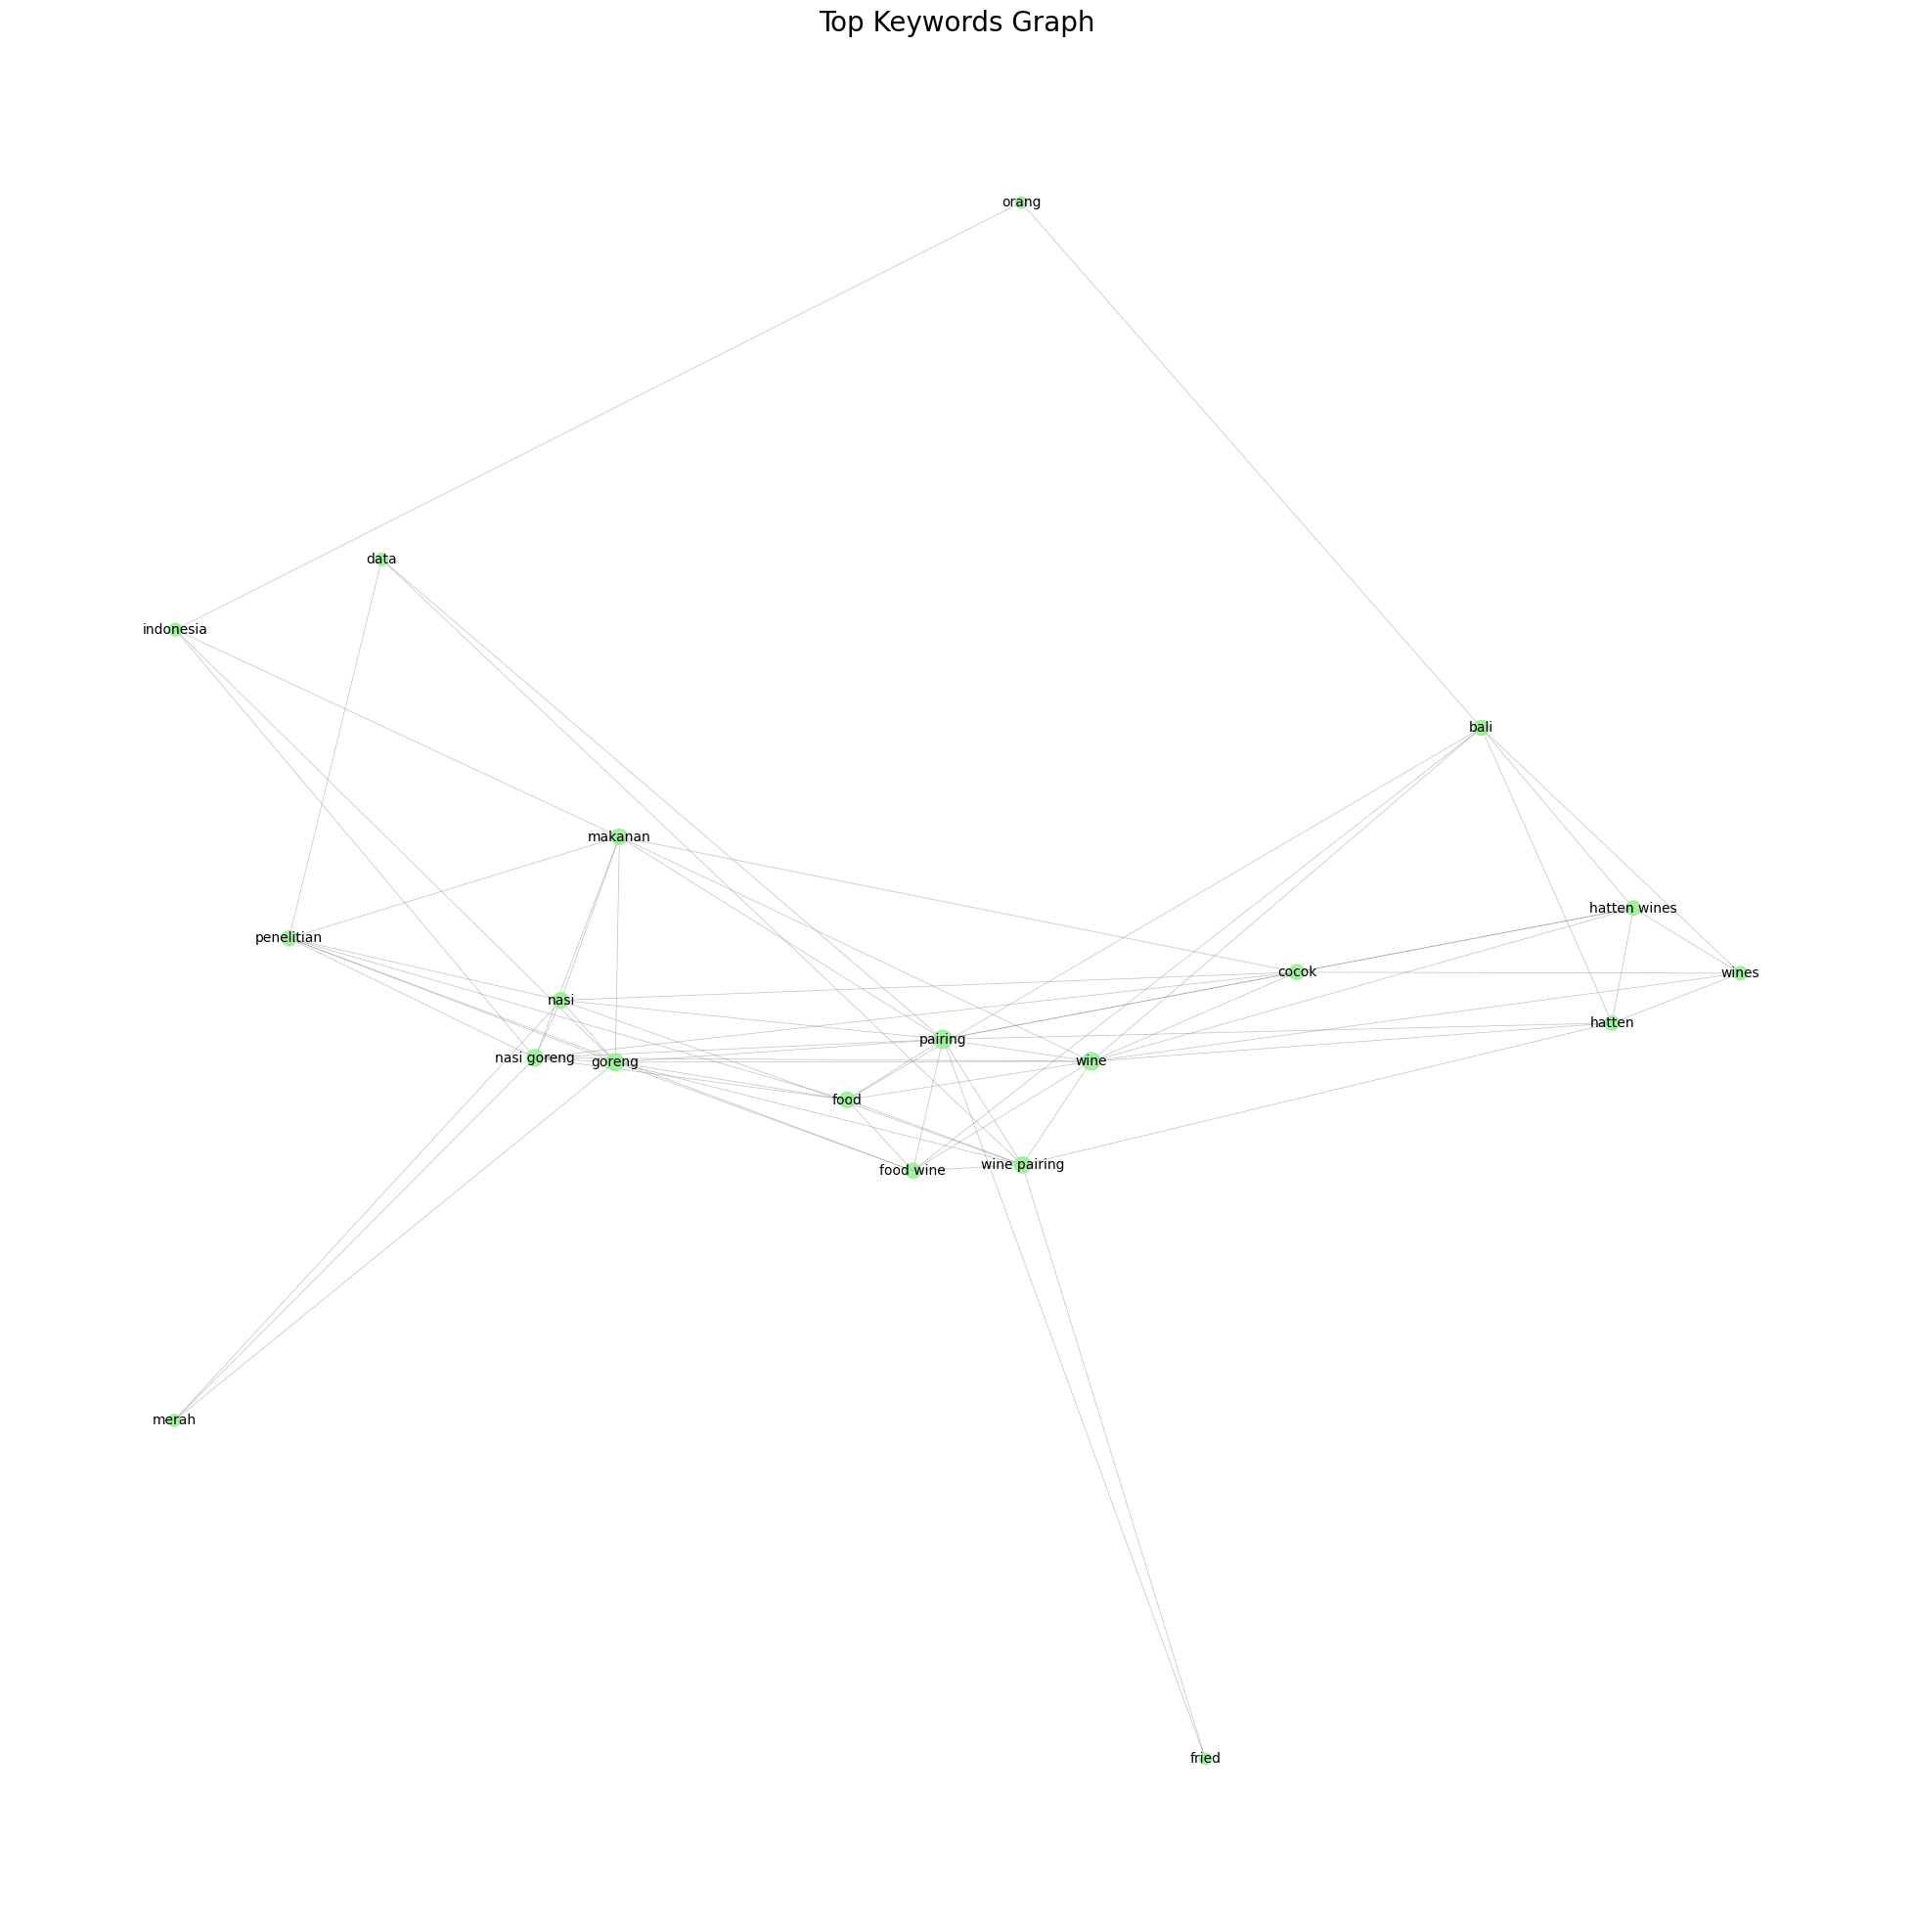

2. Menggambar Graph Seluruh Kata (Full)...
Sedang menggambar 3124 node... Mohon tunggu.


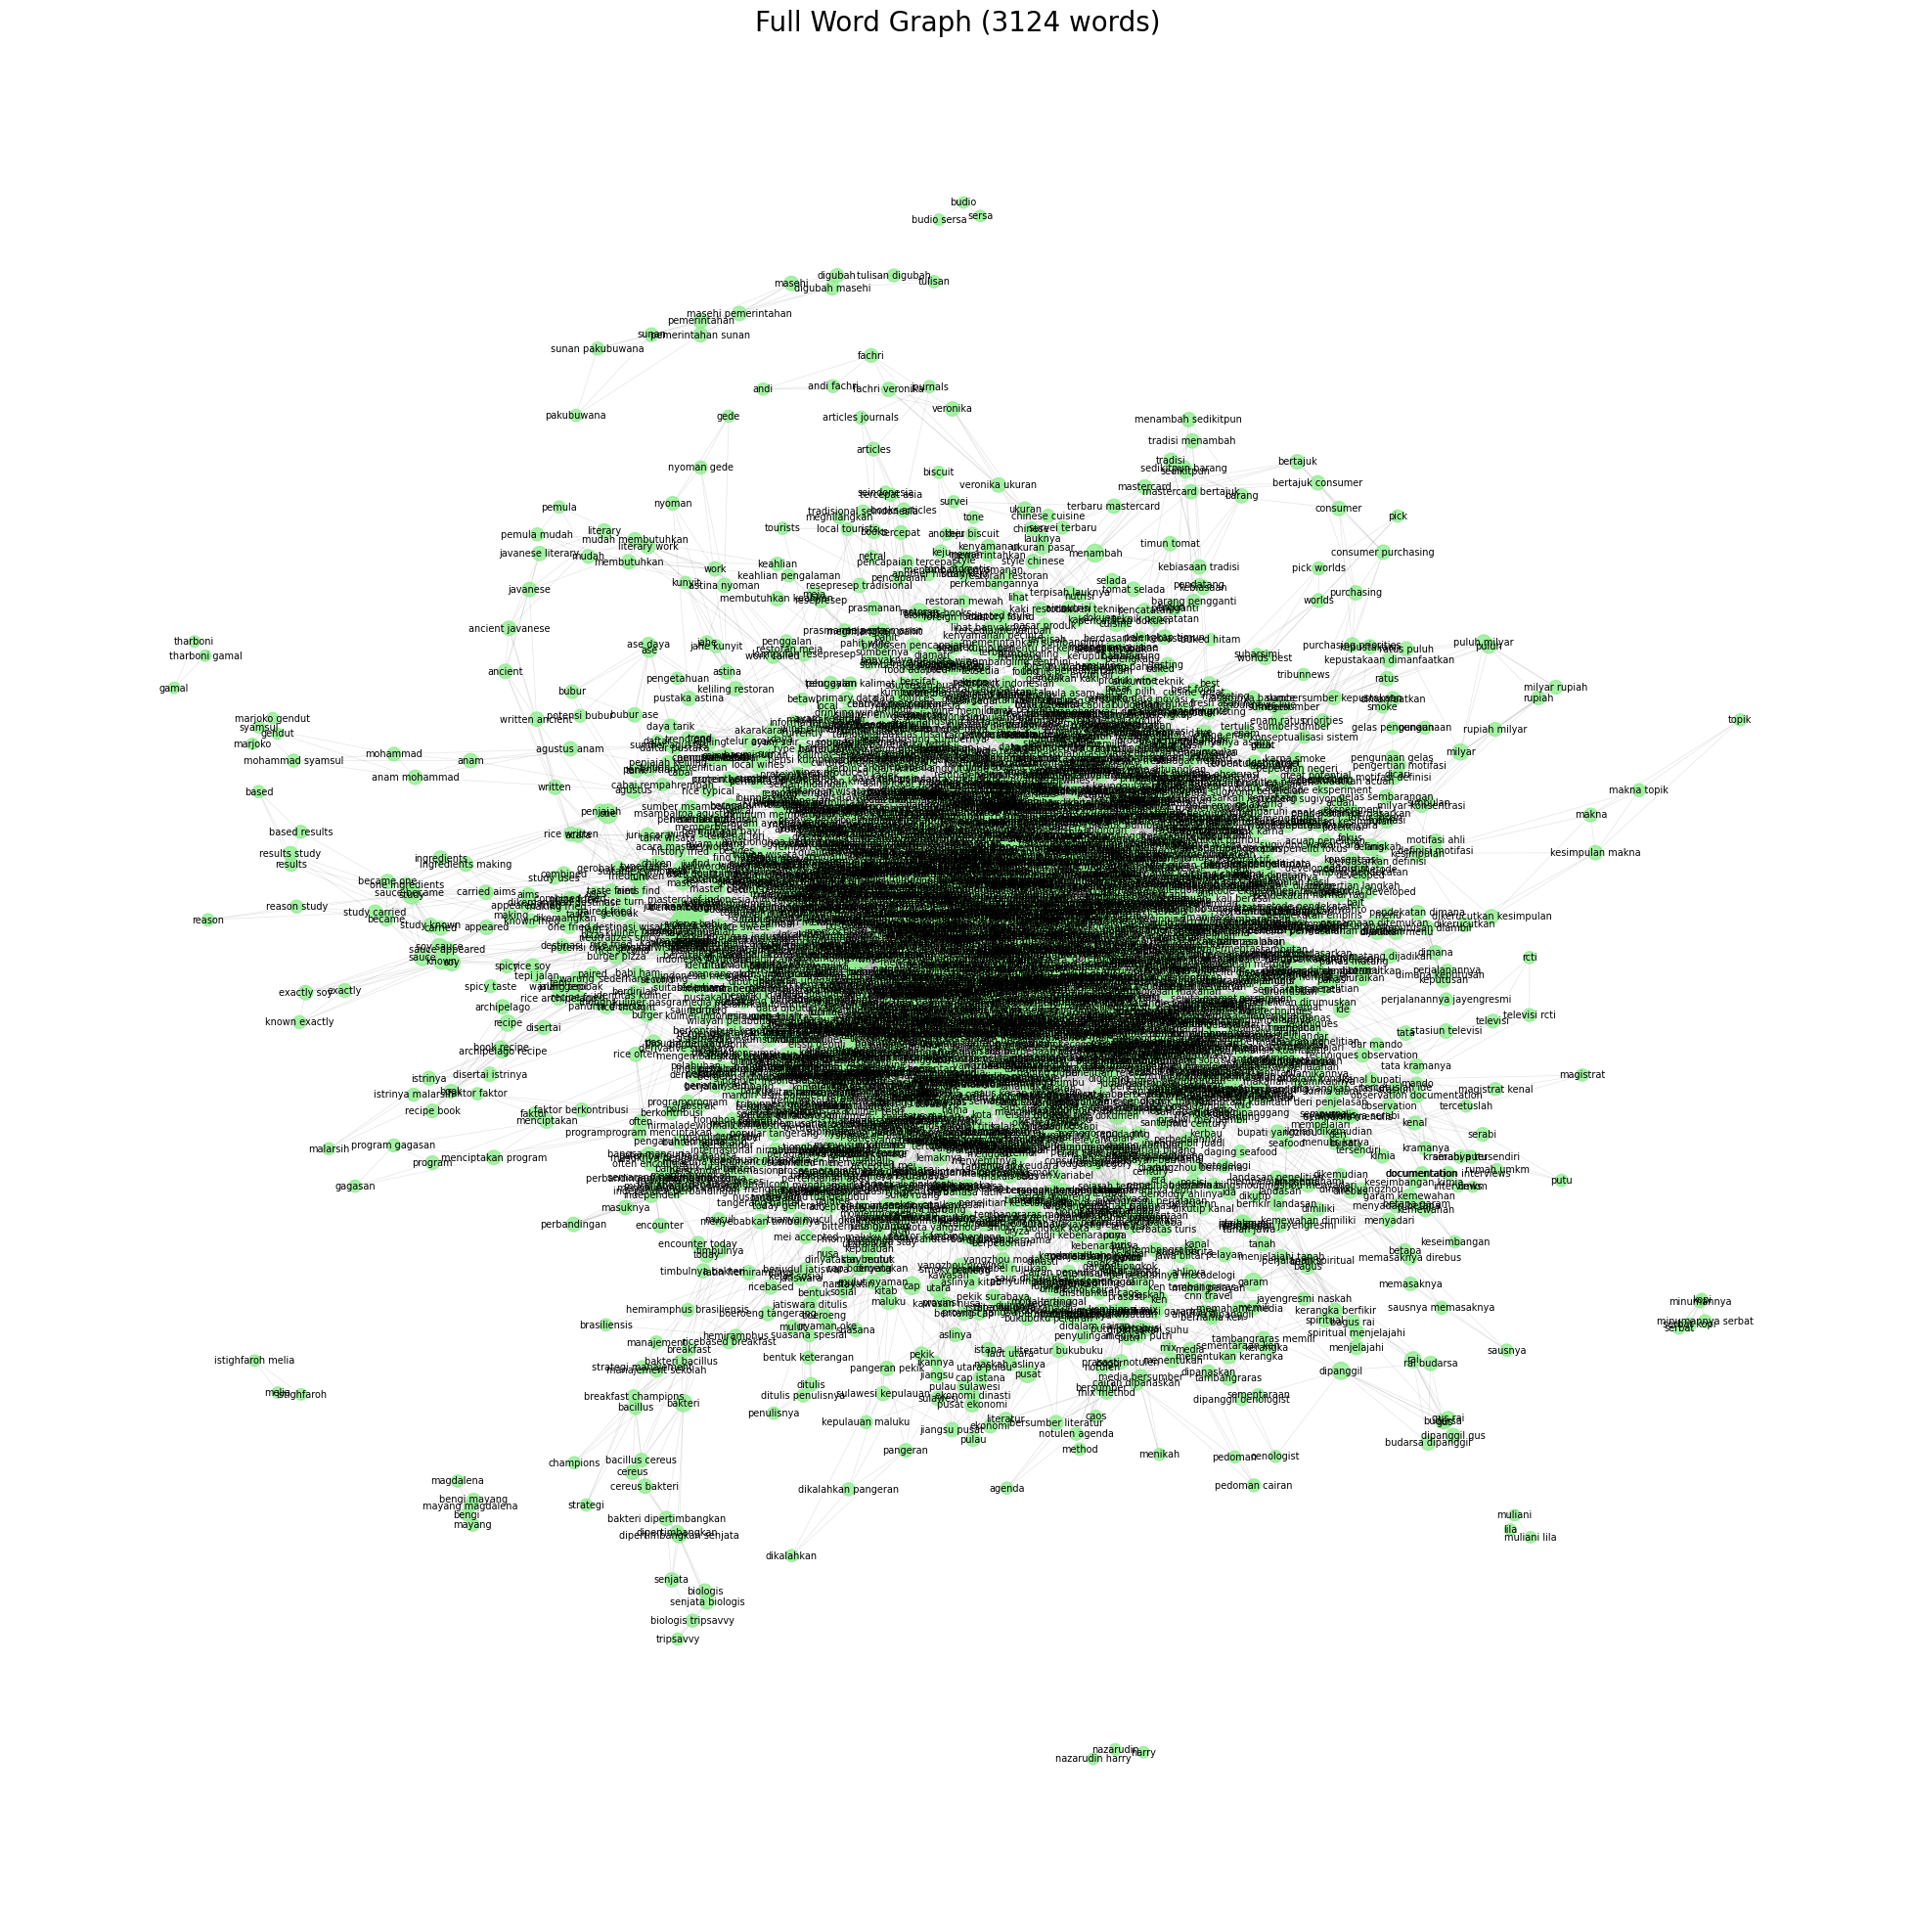

In [4]:
from google.colab import files
import os

# Hapus file PDF sebelumnya jika ada untuk menghindari konflik nama
!rm -f *.pdf

uploaded = files.upload()

for filename in uploaded.keys():
    print(f'Uploaded file: {filename}')
    pdf_file_path = filename
    print(f'Processing {pdf_file_path}...')
    main(pdf_file_path)
    break # Hanya proses file pertama yang diupload

if not uploaded:
    print("No file uploaded. Please upload a PDF file to proceed.")